# MiCoGPT v2.0 Fine-tuning (Z-Score Sorting)

本 Notebook 演示 **Z-Score 排序** 策略下的微调。
架构与 Baseline (Only Species) 保持一致：仅使用物种序列，屏蔽 Value/Condition。

**输入**：
- 语料库：`../data/vCross/ResMicroDB_90338_vCross_ZScore.pkl` (由 3.0 生成)
- 预训练模型：`../models/pretrain_vCross_zscore` (由 3.0 生成)

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import pickle
from argparse import Namespace
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from torch.utils.data import Subset
from transformers import Trainer, TrainingArguments
from transformers.trainer_callback import EarlyStoppingCallback

# --- v2.0 自定义模块 ---
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForSequenceClassification
from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTClassificationCollator
from MiCoGPT.utils_vCross.corpus_zscore import MiCoGPTCorpusZScore

# --- 复用工具函数 ---
from MiCoGPT.utils.finetune import prepare_labels_for_subset, split_train_val_by_project_stratified_with_labels
from MiCoGPT.utils.finetune_v2 import SubsetWithLabels

import warnings
warnings.filterwarnings("ignore")

## 1. 配置参数 (Configuration)

In [2]:
args = Namespace(
    # 输入语料库 (Z-Score Version)
    input="../data/vCross/ResMicroDB_90338_vCross_ZScore.pkl",
    
    # 预训练模型 (Z-Score Version)
    pretrained_model="../models/pretrain_vCross_zscore",
    
    # 输出目录
    # output="../models/finetuned_vCross_zscore",
    # log="../logs/finetuned_vCross_zscore",

    output="../models/finetuned_vCross_zscore_valLoss",
    log="../logs/finetuned_vCross_zscore_valLoss",
    
    # 任务相关
    label_col="Is_Healthy",
    split_group="A",
    val_ratio=0.2,
)

print("Args:", args)

Args: Namespace(input='../data/vCross/ResMicroDB_90338_vCross_ZScore.pkl', pretrained_model='../models/pretrain_vCross_zscore', output='../models/finetuned_vCross_zscore_valLoss', log='../logs/finetuned_vCross_zscore_valLoss', label_col='Is_Healthy', split_group='A', val_ratio=0.2)


## 2. 加载语料库 (Load Corpus)

In [3]:
print(f"Loading corpus from {args.input} ...")
with open(args.input, "rb") as f:
    corpus = pickle.load(f)
    
print(f"Loaded corpus with {len(corpus)} samples.")

Loading corpus from ../data/vCross/ResMicroDB_90338_vCross_ZScore.pkl ...
Loaded corpus with 90338 samples.


## 3. 数据准备 (Data Preparation)

In [4]:
# 1. 筛选子集
meta = corpus.metadata
valid_mask = (meta["Split_Group"] == args.split_group) & (meta[args.label_col].notna())
finetune_indices = np.where(valid_mask)[0]
finetune_subset = Subset(corpus, finetune_indices)

# 2. 生成标签
labels_tensor, all_labels_array, le, num_labels = prepare_labels_for_subset(
    all_corpus=corpus,
    subset=finetune_subset,
    label_col=args.label_col,
    verbose=True
)

# 3. 划分训练/验证集
train_subset, val_subset = split_train_val_by_project_stratified_with_labels(
    finetune_subset,
    label_col=args.label_col,
    val_ratio=args.val_ratio,
    project_col="Project_ID"
)

print(f"Train size: {len(train_subset)}")
print(f"Val size: {len(val_subset)}")

[labels] subset size=55575
[labels] num_labels=2
[labels] distribution:
0    31073
1    24502
Name: count, dtype: int64
[split] total_samples=55575, target_val~11115
[split] eligible_projects=251, eligible_samples=55398
[split] ineligible_projects=16, ineligible_samples=177
[split] label_dist (overall):
Is_Healthy
False    31073
True     24502
Name: count, dtype: int64
[split] actual_val=11115 (target~11115), train=44460
[split] label_dist (val):
Is_Healthy
False    6109
True     5006
Name: count, dtype: int64
Train size: 44460
Val size: 11115


In [5]:
def create_dataset_with_labels(subset, all_labels_array):
    indices = subset.indices
    subset_labels = torch.tensor(all_labels_array[indices], dtype=torch.long)
    return SubsetWithLabels(subset, subset_labels)

train_ds = create_dataset_with_labels(train_subset, all_labels_array)
val_ds = create_dataset_with_labels(val_subset, all_labels_array)

## 4. 加载模型 (Load Model)

In [6]:
config = MiCoGPTConfig.from_pretrained(args.pretrained_model)
config.num_labels = num_labels
print("Model Config:", config)

model = MiCoGPTForSequenceClassification.from_pretrained(
    args.pretrained_model,
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of MiCoGPTForSequenceClassification were not initialized from the model checkpoint at ../models/pretrain_vCross_zscore and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Config: MiCoGPTConfig {
  "activation_function": "gelu_new",
  "add_cross_attention": false,
  "architectures": [
    "MiCoGPTForCausalLM"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 2,
  "condition_vocab_sizes": [],
  "embd_pdrop": 0.1,
  "eos_token_id": 3,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 256,
  "n_head": 8,
  "n_inner": null,
  "n_layer": 8,
  "n_positions": 512,
  "num_bins": 52,
  "pad_token_id": 0,
  "prior_matrix_path": null,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.33.3",
  "use_cache": true,
  "vocab_size": 1121
}



## 5. 自定义 Baseline Collator (Z-Score)

同样使用 Baseline 策略，屏蔽 Value/Condition。

In [7]:
class BaselineClassificationCollator(MiCoGPTClassificationCollator):
    def __call__(self, examples):
        # 先调用父类处理 input_ids 和 labels
        batch = super().__call__(examples)
        
        # [Key] 强制将 value_ids 和 condition_ids 设为 None
        batch["value_ids"] = None
        batch["condition_ids"] = None
        
        return batch

# 必须设置 max_length=512 以避免 tensor shape 不一致问题
baseline_collator = BaselineClassificationCollator(corpus.tokenizer, max_length=512)

## 6. 训练 (Training)

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

In [9]:
training_args = TrainingArguments(
    output_dir=args.output,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir=args.log,
    logging_steps=50,
    dataloader_num_workers=0,
    report_to=["tensorboard"],
    
    # 显存优化
    # eval_accumulation_steps=60,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=baseline_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.333500,0.322170,0.860099,0.858857
2,0.252700,0.250728,0.897886,0.897493
3,0.209300,0.218749,0.909582,0.909324
4,0.210600,0.201959,0.917499,0.917338
5,0.175200,0.190259,0.920828,0.920636
6,0.164200,0.182559,0.925506,0.925405
7,0.164600,0.175073,0.929555,0.929474
8,0.151500,0.170456,0.932973,0.932932
9,0.126400,0.169112,0.934953,0.934877
10,0.117600,0.164073,0.937562,0.937471


TrainOutput(global_step=45870, training_loss=0.11588678623768715, metrics={'train_runtime': 7646.9087, 'train_samples_per_second': 581.411, 'train_steps_per_second': 18.177, 'total_flos': 2.848131995664384e+16, 'train_loss': 0.11588678623768715, 'epoch': 33.0})

## 7. 保存与分析 (Save & Analyze)

Model and LabelEncoder saved to ../models/finetuned_vCross_zscore


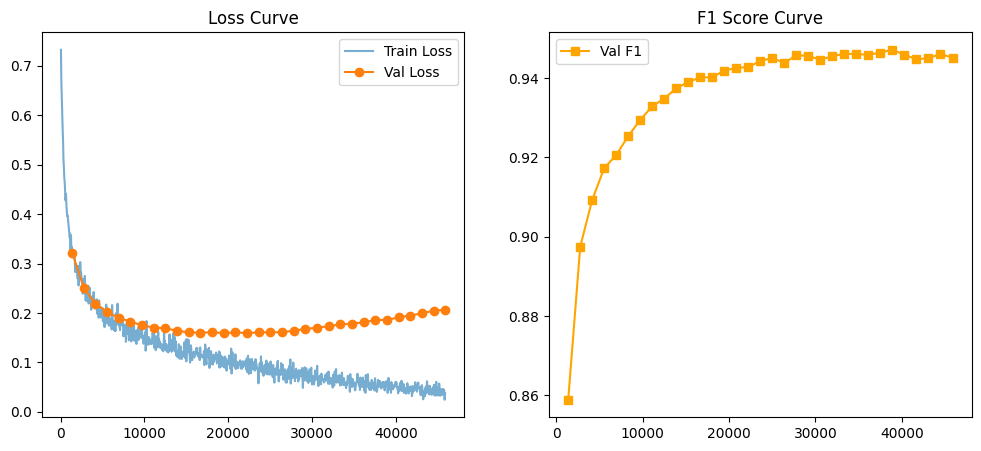

In [11]:
import joblib

# 1. 保存模型
trainer.save_model(args.output)

# 保存 Tokenizer (带补丁)
try:
    corpus.tokenizer.save_pretrained(args.output)
except NotImplementedError:
    print("Warning: tokenizer.save_pretrained() not implemented. Saving via joblib...")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")

# 保存 Label Encoder (关键)
joblib.dump(le, f"{args.output}/label_encoder.joblib")
print(f"Model and LabelEncoder saved to {args.output}")

# 2. 导出日志
log_history = trainer.state.log_history
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 3. 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]

plt.figure(figsize=(12, 5))
# Loss 曲线
plt.subplot(1, 2, 1)
if train_steps:
    plt.plot(train_steps, train_loss, label="Train Loss", alpha=0.6)
if eval_steps:
    plt.plot(eval_steps, eval_loss, label="Val Loss", marker="o")
plt.title("Loss Curve")
plt.legend()

# F1 曲线
plt.subplot(1, 2, 2)
if eval_steps and eval_f1:
    plt.plot(eval_steps, eval_f1, label="Val F1", color="orange", marker="s")
plt.title("F1 Score Curve")
plt.legend()

plt.savefig(f"{args.output}/training_curve.png")
plt.show()

Model and LabelEncoder saved to ../models/finetuned_vCross_zscore


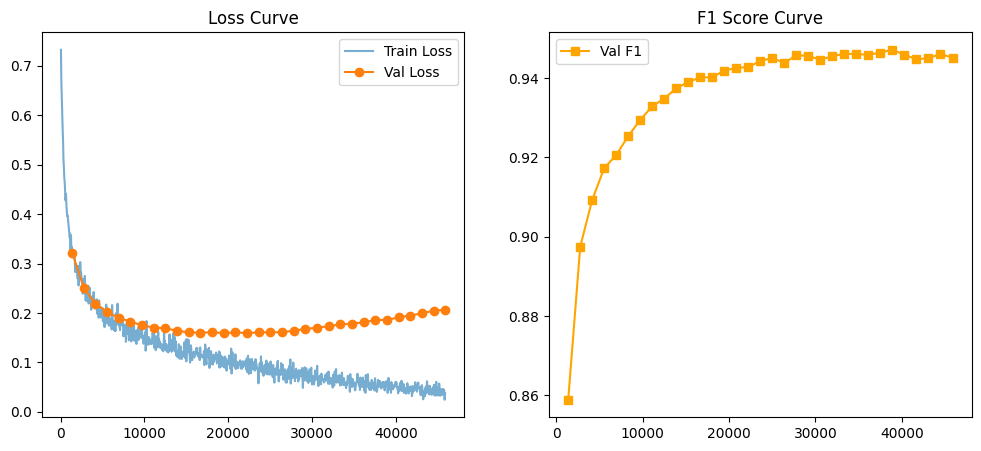

In [12]:
# 1. 保存模型
trainer.save_model(args.output)

# [Patch] Tokenizer 保存补丁
# 尝试使用标准 save_pretrained，如果报错(NotImplementedError)，则使用 joblib 备份
try:
    corpus.tokenizer.save_pretrained(args.output)
    print(f"Tokenizer saved to {args.output} via save_pretrained")
except NotImplementedError:
    import joblib
    print("Warning: Tokenizer.save_pretrained not implemented. Saving tokenizer object via joblib instead.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")
except Exception as e:
    # 兜底：任何其他错误也尝试用 joblib 救一下
    import joblib
    print(f"Warning: Failed to save tokenizer via save_pretrained ({e}). Saving via joblib.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")

# 保存 Label Encoder (关键)
import joblib
joblib.dump(le, f"{args.output}/label_encoder.joblib")
print(f"Model and LabelEncoder saved to {args.output}")

# 2. 导出日志
log_history = trainer.state.log_history
import json
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 3. 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]

plt.figure(figsize=(12, 5))

# Loss 曲线
plt.subplot(1, 2, 1)
if train_steps: plt.plot(train_steps, train_loss, label="Train Loss", alpha=0.6)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Val Loss", marker="o")
plt.title("Loss Curve")
plt.legend()

# F1 曲线
plt.subplot(1, 2, 2)
if eval_steps and eval_f1: 
    plt.plot(eval_steps, eval_f1, label="Val F1", color="orange", marker="s")
plt.title("F1 Score Curve")
plt.legend()

plt.savefig(f"{args.output}/training_curve.png")
plt.show()

In [4]:
# 0. (可选) 重新加载模型和配置 (如果内存已清空)
# 如果你刚运行完上面的训练代码，可以跳过此 Cell；
# 如果你是重新打开 Notebook，请运行此 Cell 来加载训练好的模型。

import joblib
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForSequenceClassification

def create_dataset_with_labels(subset, all_labels_array):
    # subset.indices 是在 corpus 中的全局索引
    indices = subset.indices
    # 从全局 labels 数组中提取对应标签
    subset_labels = torch.tensor(all_labels_array[indices], dtype=torch.long)
    return SubsetWithLabels(subset, subset_labels)

# 检查变量是否存在，如果不存在则加载
if 'trainer' not in locals() or 'model' not in locals() or 'le' not in locals():
    print(f"Loading model from {args.output} ...")
    
    # 1. 加载 Label Encoder
    le_path = f"{args.output}/label_encoder.joblib"
    if os.path.exists(le_path):
        le = joblib.load(le_path)
        print("Label Encoder loaded.")
    else:
        raise FileNotFoundError(f"Label Encoder not found at {le_path}. Please run training first.")

    # 2. 加载模型
    # 注意：这里需要 num_labels，可以从 le 推断
    if hasattr(le, "classes_"):
        num_labels = len(le.classes_)
    else:
        num_labels = len(le.categories_[0])
        
    config = MiCoGPTConfig.from_pretrained(args.output)
    model = MiCoGPTForSequenceClassification.from_pretrained(args.output, config=config)
    
    # 3. 重新定义 Collator (ValueCondition: 屏蔽 Value)
    # 确保前面已经定义了 ValueConditionClassificationCollator 类
    if 'ValueConditionClassificationCollator' not in locals():
        class ValueConditionClassificationCollator(MiCoGPTClassificationCollator):
            def __call__(self, examples):
                batch = super().__call__(examples)
                batch["value_ids"] = None
                return batch

    # 假设 corpus 已加载
    if 'corpus' in locals():
        tokenizer = corpus.tokenizer
    else:
        print("Warning: corpus not in memory. Using tokenizer from saved model.")
        raise ValueError("Please run the 'Load Corpus' cell above to load the tokenizer first.")
        
    value_condition_collator = ValueConditionClassificationCollator(tokenizer)
    
    # 4. 重建 Trainer
    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir=args.output, per_device_eval_batch_size=32),
        data_collator=value_condition_collator
    )
    print("Model and Trainer restored.")
else:
    print("Model and Trainer already in memory. Skipping reload.")

Loading model from ../models/finetuned_vCross_zscore ...
Label Encoder loaded.
Model and Trainer restored.


In [5]:
from MiCoGPT.utils.mgm_utils import eval_and_save

# 1. 准备测试集 (Split_Group = B)
print("Preparing Test Set (Split_Group='B')...")
meta = corpus.metadata
test_mask = (meta["Split_Group"] == "B") & (meta[args.label_col].notna())
test_indices = np.where(test_mask)[0]
test_subset = Subset(corpus, test_indices)

print(f"Test subset size: {len(test_subset)}")

# 2. 生成测试集标签 (复用训练时的 Encoder)
# 注意：这里必须传入训练时 fit 好的 le (encoder)，以保证标签 ID 映射一致
test_labels_tensor, test_all_labels, _, _ = prepare_labels_for_subset(
    all_corpus=corpus,
    subset=test_subset,
    label_col=args.label_col,
    encoder=le, 
    verbose=True
)

# 3. 包装 Dataset
test_ds = create_dataset_with_labels(test_subset, test_all_labels)

# 4. 预测
print("Running prediction...")
# Trainer 会自动使用最佳模型 (load_best_model_at_end=True)
predictions = trainer.predict(test_ds)
y_score = predictions.predictions
y_true = predictions.label_ids

# 5. 评估并保存
# 获取类别名称
if hasattr(le, "categories_"):
    # OneHotEncoder
    label_names = list(le.categories_[0])
else:
    # LabelEncoder
    label_names = [str(c) for c in le.classes_]

save_dir = f"{args.output}/prediction_B"
os.makedirs(save_dir, exist_ok=True)

print(f"Saving results to {save_dir}...")
eval_and_save(
    y_score=y_score,
    y_true=y_true,
    label_names=label_names,
    save_dir=save_dir,
    activation="softmax" # 模型输出 logits，需要 softmax 归一化
)

Preparing Test Set (Split_Group='B')...
Test subset size: 13901
[labels] subset size=13901
[labels] num_labels=2
[labels] distribution:
0    7776
1    6125
Name: count, dtype: int64
Running prediction...


Saving results to ../models/finetuned_vCross_zscore/prediction_B...
Evaluating biome source: False
         TN    FP    FN    TP     Acc      Sn      Sp     TPR     FPR      Rc  \
t                                                                               
0.000     0  6125     0  7776  0.5594  1.0000  0.0000  1.0000  1.0000  1.0000   
0.001   301  5824    68  7708  0.5761  0.9913  0.0491  0.9913  0.9509  0.9913   
0.002   384  5741    95  7681  0.5802  0.9878  0.0627  0.9878  0.9373  0.9878   
0.003   430  5695   102  7674  0.5830  0.9869  0.0702  0.9869  0.9298  0.9869   
0.004   458  5667   113  7663  0.5842  0.9855  0.0748  0.9855  0.9252  0.9855   
...     ...   ...   ...   ...     ...     ...     ...     ...     ...     ...   
0.997  3836  2289  2379  5397  0.6642  0.6941  0.6263  0.6941  0.3737  0.6941   
0.998  4072  2053  2645  5131  0.6620  0.6599  0.6648  0.6599  0.3352  0.6599   
0.999  4444  1681  3115  4661  0.6550  0.5994  0.7256  0.5994  0.2744  0.5994   
1.000  612

,Acc,Sn,Sp,TPR,FPR,Rc,Pr,F1,F-max,ROC-AUC,PR-AUC
0,0.5000,1.0000,0.0000,1.0000,1.0000,1.0000,0.5000,0.6646,0.6955,0.7019,0.5607
1,0.6156,0.8584,0.3243,0.8584,0.6758,0.8584,0.5788,0.6865,0.6955,0.7019,0.5607
2,0.6211,0.8263,0.3613,0.8263,0.6387,0.8263,0.5893,0.6794,0.6955,0.7019,0.5607
3,0.6236,0.8066,0.3822,0.8066,0.6178,0.8066,0.5956,0.6738,0.6955,0.7019,0.5607
4,0.6257,0.7950,0.3957,0.7950,0.6043,0.7950,0.6009,0.6708,0.6955,0.7019,0.5607
...,...,...,...,...,...,...,...,...,...,...,...
997,0.6236,0.3822,0.8066,0.3822,0.1934,0.3822,0.7552,0.4136,0.6955,0.7019,0.5607
998,0.6211,0.3613,0.8263,0.3613,0.1737,0.3613,0.7579,0.4012,0.6955,0.7019,0.5607
999,0.6156,0.3243,0.8584,0.3243,0.1415,0.3243,0.7753,0.3765,0.6955,0.7019,0.5607
1000,0.5000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.6955,0.7019,0.5607


In [4]:
# 0. (可选) 重新加载模型和配置 (如果内存已清空)
# 如果你刚运行完上面的训练代码，可以跳过此 Cell；
# 如果你是重新打开 Notebook，请运行此 Cell 来加载训练好的模型。

import joblib
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForSequenceClassification

def create_dataset_with_labels(subset, all_labels_array):
    # subset.indices 是在 corpus 中的全局索引
    indices = subset.indices
    # 从全局 labels 数组中提取对应标签
    subset_labels = torch.tensor(all_labels_array[indices], dtype=torch.long)
    return SubsetWithLabels(subset, subset_labels)

# 检查变量是否存在，如果不存在则加载
if 'trainer' not in locals() or 'model' not in locals() or 'le' not in locals():
    print(f"Loading model from {args.output} ...")
    
    # 1. 加载 Label Encoder
    le_path = f"{args.output}/label_encoder.joblib"
    if os.path.exists(le_path):
        le = joblib.load(le_path)
        print("Label Encoder loaded.")
    else:
        raise FileNotFoundError(f"Label Encoder not found at {le_path}. Please run training first.")

    # 2. 加载模型
    # 注意：这里需要 num_labels，可以从 le 推断
    if hasattr(le, "classes_"):
        num_labels = len(le.classes_)
    else:
        num_labels = len(le.categories_[0])
        
    config = MiCoGPTConfig.from_pretrained(args.output)
    model = MiCoGPTForSequenceClassification.from_pretrained(args.output, config=config)
    
    # 3. 重新定义 Collator (ValueCondition: 屏蔽 Value)
    # 确保前面已经定义了 ValueConditionClassificationCollator 类
    if 'ValueConditionClassificationCollator' not in locals():
        class ValueConditionClassificationCollator(MiCoGPTClassificationCollator):
            def __call__(self, examples):
                batch = super().__call__(examples)
                batch["value_ids"] = None
                return batch

    # 假设 corpus 已加载
    if 'corpus' in locals():
        tokenizer = corpus.tokenizer
    else:
        print("Warning: corpus not in memory. Using tokenizer from saved model.")
        raise ValueError("Please run the 'Load Corpus' cell above to load the tokenizer first.")
        
    value_condition_collator = ValueConditionClassificationCollator(tokenizer)
    
    # 4. 重建 Trainer
    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir=args.output, per_device_eval_batch_size=32),
        data_collator=value_condition_collator
    )
    print("Model and Trainer restored.")
else:
    print("Model and Trainer already in memory. Skipping reload.")

Loading model from ../models/finetuned_vCross_zscore_valLoss ...
Label Encoder loaded.
Model and Trainer restored.


In [5]:
from MiCoGPT.utils.mgm_utils import eval_and_save

# 1. 准备测试集 (Split_Group = B)
print("Preparing Test Set (Split_Group='B')...")
meta = corpus.metadata
test_mask = (meta["Split_Group"] == "B") & (meta[args.label_col].notna())
test_indices = np.where(test_mask)[0]
test_subset = Subset(corpus, test_indices)

print(f"Test subset size: {len(test_subset)}")

# 2. 生成测试集标签 (复用训练时的 Encoder)
# 注意：这里必须传入训练时 fit 好的 le (encoder)，以保证标签 ID 映射一致
test_labels_tensor, test_all_labels, _, _ = prepare_labels_for_subset(
    all_corpus=corpus,
    subset=test_subset,
    label_col=args.label_col,
    encoder=le, 
    verbose=True
)

# 3. 包装 Dataset
test_ds = create_dataset_with_labels(test_subset, test_all_labels)

# 4. 预测
print("Running prediction...")
# Trainer 会自动使用最佳模型 (load_best_model_at_end=True)
predictions = trainer.predict(test_ds)
y_score = predictions.predictions
y_true = predictions.label_ids

# 5. 评估并保存
# 获取类别名称
if hasattr(le, "categories_"):
    # OneHotEncoder
    label_names = list(le.categories_[0])
else:
    # LabelEncoder
    label_names = [str(c) for c in le.classes_]

save_dir = f"{args.output}/prediction_B"
os.makedirs(save_dir, exist_ok=True)

print(f"Saving results to {save_dir}...")
eval_and_save(
    y_score=y_score,
    y_true=y_true,
    label_names=label_names,
    save_dir=save_dir,
    activation="softmax" # 模型输出 logits，需要 softmax 归一化
)

Preparing Test Set (Split_Group='B')...
Test subset size: 13901
[labels] subset size=13901
[labels] num_labels=2
[labels] distribution:
0    7776
1    6125
Name: count, dtype: int64
Running prediction...


Saving results to ../models/finetuned_vCross_zscore_valLoss/prediction_B...
Evaluating biome source: False
         TN    FP    FN    TP     Acc      Sn      Sp     TPR     FPR      Rc  \
t                                                                               
0.000     0  6125     0  7776  0.5594  1.0000  0.0000  1.0000  1.0000  1.0000   
0.001    86  6039    14  7762  0.5646  0.9982  0.0140  0.9982  0.9860  0.9982   
0.002   123  6002    23  7753  0.5666  0.9970  0.0201  0.9970  0.9799  0.9970   
0.003   143  5982    34  7742  0.5672  0.9956  0.0233  0.9956  0.9767  0.9956   
0.004   156  5969    40  7736  0.5677  0.9949  0.0255  0.9949  0.9745  0.9949   
...     ...   ...   ...   ...     ...     ...     ...     ...     ...     ...   
0.997  5095  1030  3941  3835  0.6424  0.4932  0.8318  0.4932  0.1682  0.4932   
0.998  5370   755  4348  3428  0.6329  0.4408  0.8767  0.4408  0.1233  0.4408   
0.999  5740   385  5162  2614  0.6010  0.3362  0.9371  0.3362  0.0629  0.3362   
1.

,Acc,Sn,Sp,TPR,FPR,Rc,Pr,F1,F-max,ROC-AUC,PR-AUC
0,0.5000,1.0000,0.0000,1.0000,1.0000,1.0000,0.5000,0.6646,0.7088,0.7321,0.6386
1,0.5828,0.9676,0.1751,0.9676,0.8249,0.9676,0.5444,0.6968,0.7088,0.7321,0.6386
2,0.5998,0.9368,0.2304,0.9368,0.7696,0.9368,0.5581,0.6990,0.7088,0.7321,0.6386
3,0.6048,0.9137,0.2583,0.9137,0.7418,0.9137,0.5640,0.6962,0.7088,0.7321,0.6386
4,0.6080,0.8971,0.2774,0.8971,0.7226,0.8971,0.5684,0.6937,0.7088,0.7321,0.6386
...,...,...,...,...,...,...,...,...,...,...,...
997,0.6048,0.2583,0.9137,0.2583,0.0863,0.2583,0.7981,0.3261,0.7088,0.7321,0.6386
998,0.5998,0.2304,0.9368,0.2304,0.0632,0.2304,0.8310,0.3062,0.7088,0.7321,0.6386
999,0.5828,0.1751,0.9676,0.1751,0.0323,0.1751,0.8658,0.2564,0.7088,0.7321,0.6386
1000,0.5000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.7088,0.7321,0.6386
